In [2]:
#libraries
import datetime
import pandas as pd
from transform_functions import *

In [3]:
#accetable values for individual variables in the data set; in case the value for the variable is not in the subdictionary belonging to it it will be assign NC value and then removed from the data set for model estimation
rename_dict = {"drive": {"4x2": "4x2", "4x4": "4x4"}, 
               "car_style": {"Cabriolet": "sport", 
                             "Coupe": "sport",
                            "Pick-up": "offroad", 
                            "SUV / offroad": "offroad", 
                             "Sedans / saloons": "sedan", 
                             "Compact": "sedan", 
                             "Station Wagon": "station_wagon", 
                             "MPV/VAN": "large", 
                             "Cargo VAN": "large"},
                "emission_class": {'Euro 1': "old",
                                       "Euro 2": "old", 
                                       "Euro 3": "old", 
                                       "Euro 4": "old", 
                                       "Euro 5a": "old", 
                                       "Euro 5b": "old",  
                                       "Euro 6b": "new", 
                                       "Euro 6c": "new", 
                                        "Euro 6d-TEMP": "new", 
                                        "Euro 6d": "new"},
                "door_count": {"2/3 doors": "2_3", 
                               "4/5 doors": "4_5"},
                "color": {"Blue": "s", "Black": "s",
                             "Beige": "n", "Brown": "n", "Gold": "n", "Green": "n", 
                             "Grey": "s", "Orange": "n", "Purple": "n", "Red": "n", 
                             "Silver": "s", "White": "s", "Yellow": "n"},
                "fuel_type": {"Diesel": "diesel", "Petrol": "petrol"}
            }
#range of values for the 3 variables in order for the observation to be included in the data set for the estimation
filter_val = {"cubic_capacity": {"min": 0.4, "max": 7.3},
              "fuel_consumption_combined": {"min": 3, "max": 30},
              "number_of_seats": {"min": 1, "max": 10}
}

# Intro

The purpose of this report is to create data set ready to use in the price prediction model training based on the information I gained from the initial data exploration (data_exploration report). 

In [4]:
#read data
data = pd.read_csv("../data/car_data.csv")
data.head()
features_df = pd.read_csv('../data/features_df.csv')

In [5]:
#new data_frame
cleaned_df = pd.DataFrame()
#constants
date_download = datetime.datetime(2023, 3, 24)

# Power

count    672825.000000
mean        128.505042
std          68.717050
min           4.000000
25%          85.000000
50%         110.000000
75%         143.000000
max         588.000000
Name: power, dtype: float64


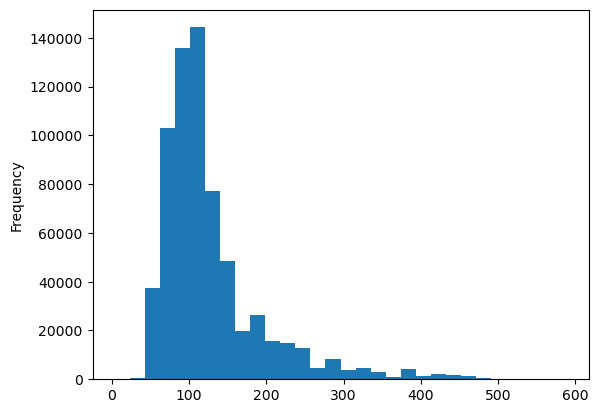

In [6]:
print(data["power"].describe())
data["power"].plot.hist(bins=30)
cleaned_df["power"] = data["power"]

In case of power, there are no missing values, maximum and minimum values seem reasonable, so there is no need to change anything about this variable.

# Cubic Capacity

In [7]:
print(data["cubic_capacity"].describe())
cleaned_df["cubic_capacity"] = data["cubic_capacity"] / 1000

count    643259.000000
mean       1760.318540
std         695.242679
min           0.000000
25%        1332.000000
50%        1598.000000
75%        1993.000000
max       83590.000000
Name: cubic_capacity, dtype: float64


In case of cubic capacity, there some observations with too high or too low values, so it is necessary to clear these values. Additionally, we transform the variable from cubic centimetres to litres.

# Fuel Consumption

In [8]:
print(data["fuel_consumption_combined"].describe())
cleaned_df["fuel_consumption_combined"] = data["fuel_consumption_combined"]

count    651834.000000
mean          5.695248
std           3.886920
min           0.000000
25%           4.600000
50%           5.100000
75%           6.100000
max         809.000000
Name: fuel_consumption_combined, dtype: float64


In case of fuel consumption, there can be again found values that do not makes sense so it will be necessary to filter them out of data set. Both 0 value of fuel consumption and 809 are obviously not possible. In case of fuel consunmption it is hard to establish what is the possible range that this metric can  attain so in the end I settled for the range between 3 and 30 litres per 100 kilometres.

# Carbon Dioxide Emission

In [9]:
print(data["carbon_dioxide_emission"].describe())
cleaned_df["co2_emission"] = data["carbon_dioxide_emission"]

count    672768.000000
mean        125.463684
std          49.364135
min           0.000000
25%         109.000000
50%         125.000000
75%         147.000000
max        1258.000000
Name: carbon_dioxide_emission, dtype: float64


# Mileage

In [10]:
print(data["mileage"].describe())
cleaned_df["mileage"] = data["mileage"] / 1000

count    672826.000000
mean      40339.856209
std       37238.677201
min           0.000000
25%       10548.000000
50%       29500.000000
75%       60600.000000
max      175000.000000
Name: mileage, dtype: float64


The mileage variable is transformed from kilometres to 1000s of kilometres for future easier interpretation. The range of values for this variable between 0 and 175 000 seems reasonable.

# Age of Vehicle

In [11]:
cleaned_df["vehicle_age"] = (date_download 
                             - (pd.to_datetime(data["manufacture_date"])
                                )).dt.days

In case of age of vehicle, I use number of days since the vehicle manufacturing as approximation of vehicle age in the future price prediction. In the data exploration report of this report I established that there are no missing values for this variable and they are all in a reasonable range for age of used vehicle, so there is no need to deal with this variable further. 

# Car Maker

In [12]:
brand_counts = data["brand"].value_counts()
other_counts = brand_counts[brand_counts < 5000]
cleaned_df["carmaker"] = data["brand"]
cleaned_df.loc[cleaned_df["carmaker"].isin(other_counts.index), "carmaker"] = "other_brand" 
cleaned_df["carmaker"] = (cleaned_df["carmaker"].str.lower()
                          .apply(remove_accents)
                          .str.replace("-", "_")
                          .str.replace(" ", "_"))
if "carmaker_bmw" not in cleaned_df.columns:
    col_copy = cleaned_df["carmaker"]
    cleaned_df = pd.get_dummies(cleaned_df, columns=["carmaker"])
    cleaned_df["carmaker"] = col_copy

Given how many different car makers there are in the data set often with very low number of observations, we transform the variable, so every car maker with less than 5000 observations is grouped into single value "other carmaker". I also create a dummy variable for each fo the values.

# Fuel Type

In [13]:
cleaned_df["fuel_type"] = data["fuel_type"]
cleaned_df["fuel_type"] = cleaned_df["fuel_type"].apply(
    lambda x: rename_cols(x, rename_dict["fuel_type"])
    )
if "fuel_type_diesel" not in cleaned_df.columns:
    col_copy = cleaned_df["fuel_type"]
    cleaned_df = pd.get_dummies(cleaned_df, columns=["fuel_type"])
    cleaned_df["fuel_type"] = col_copy

In case of fuel type, there is a lot of observations with an alternative type to engine (either electric or hybrid or gas-fueled). To make the analysis simplier because there are some variables there are incompatible for the alternative types of engine I decided to restrict my analysis only to tradiotional combustion engines. 

# Transmission Type

In [14]:
cleaned_df["transmission"] = data["transmission"]
print(cleaned_df["transmission"].value_counts())
cleaned_df["transmission"] = cleaned_df["transmission"].str.lower()
if "transmission_automatic" not in cleaned_df.columns:
    col_copy = cleaned_df["transmission"]
    cleaned_df = pd.get_dummies(cleaned_df, columns=["transmission"])
    cleaned_df["transmission"] = col_copy

transmission
Automatic    428868
Manual       243958
Name: count, dtype: int64


# Drive

In [15]:
cleaned_df["drive"] = data["drive"]
print(cleaned_df["drive"].value_counts())
cleaned_df["drive"] = cleaned_df["drive"].apply(
    lambda x: rename_cols(x, rename_dict["drive"])
    )
if "drive_4x4" not in cleaned_df.columns:
    col_copy = cleaned_df["drive"]
    cleaned_df = pd.get_dummies(cleaned_df, columns=["drive"])
    cleaned_df["drive"] = col_copy

drive
4x2                  512974
4x4                  159851
Front wheel drive         1
Name: count, dtype: int64


# Car Style

In [16]:
cleaned_df["car_style"] = data["car_style"]
print(cleaned_df["car_style"].value_counts())
cleaned_df["car_style"] = cleaned_df["car_style"].apply(
    lambda x: rename_cols(x, rename_dict["car_style"])
    )
if "car_style_sport" not in cleaned_df.columns:
    col_copy = cleaned_df["car_style"]
    cleaned_df = pd.get_dummies(cleaned_df, columns=["car_style"])
    cleaned_df["car_style"] = col_copy

car_style
SUV / offroad       266443
Compact             134795
Station Wagon       102186
Sedans / saloons     69715
MPV/VAN              46866
Coupe                16841
Cabriolet            16660
Cargo VAN            11274
Pick-up               3969
Other car styles      1917
Name: count, dtype: int64


Given that there quite a few possible car styles to be found in our data set and in same cases two categories can not be clearly distinguished from each other (sedan can be compact at the same time), I grouped several of the categories together in a following way. Cabriolet and coupe in sport category, compact sedan/saloon into sedan category, MPV/VAN Cargo VAN into large category and, finally, SUV/ offroad and pick-up into offroad category. The remaining category Other car styles is then to be removed from the data set. 

# Emission Class

In [17]:
data["emission_standard"] = data["registration_date"].apply(lambda x: get_emissions_standard(x))
cleaned_df["emission_class"] = data["emission_standard"]
print(cleaned_df["emission_class"].value_counts())
cleaned_df["emission_class"] = cleaned_df["emission_class"].apply(
    lambda x: rename_cols(x, rename_dict["emission_class"])
    )
if "emission_class_old" not in cleaned_df.columns:
    col_copy = cleaned_df["emission_class"]
    cleaned_df = pd.get_dummies(cleaned_df, columns=["emission_class"])
    cleaned_df["emission_class"] = col_copy

emission_class
Euro 6d         314537
Euro 6d-TEMP    140898
Euro 6c          94796
Euro 6b          91752
Euro 5b          21097
Euro 5a           7391
Euro 4            2355
Name: count, dtype: int64


In case of emission standard, there are again many different classes available in the data set but given that most of the vehicles come from last few years, there is much more vehicles with some variation of Euro 6 standard then any other. I solve this in the data set by only differentiating between new (Euro 6) and old emission standard where the variable attains 1 when it has any type of  emission standard Euro 6 and 0 otherwise.

# Door Count

In [18]:
log_door_count = unify_val(df=data, col_name="door_count")
cleaned_df["door_count"] = data["door_count"]
cleaned_df["door_count"] = cleaned_df["door_count"].apply(
    lambda x: rename_cols(x, rename_dict["door_count"])
    )
if "door_count_2_3" not in cleaned_df.columns:
    col_copy = cleaned_df["door_count"]
    cleaned_df = pd.get_dummies(cleaned_df, columns=["door_count"])
    cleaned_df["door_count"] = col_copy

c:\Users\jziac\OneDrive\Documents\programovani\projekty\ml_cars\reports\functions.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, log])


            model  brand  share  n_obs  n_value  n_distinct
type                                                       
most_other    582    582    582    582      582         582
undecided     129    129    129    129      129         129


In case of door count most of the vehicles have either 2-3 or 4-5 number of doors. Since there is only a very small number of 6 or 7 door cars in our data set we remove them. Further, there also a lot of observations with missing values, so using the fact that each model has high probability of having only either 2-3 or 4-5 doors available, we assign values of door_count to these observations in case that there is observation of same model with existing door count entry available in the data set and its distribution for the concrete model is sufficiently homogenous (95% for one value of door count) at the same time.

# Number of Seats

In [19]:
log_door_count = unify_val(df=data, col_name="number_of_seats")
cleaned_df["number_of_seats"] = data["number_of_seats"]

c:\Users\jziac\OneDrive\Documents\programovani\projekty\ml_cars\reports\functions.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, log])


            model  brand  share  n_obs  n_value  n_distinct
type                                                       
most_other    573    573    573    573      573         573
undecided     295    295    295    295      295         295


In case of number of seats, we again assign their value in case it is missing based on other observations of the same car model in the data set in the same fashion as in the case of door count. 

# Colour

In [20]:
cleaned_df["color"] = data["color"]
print(cleaned_df["color"].value_counts())
cleaned_df["color"] = cleaned_df["color"].apply(
    lambda x: rename_cols(x, rename_dict["color"])
    )
if "color_standard" not in cleaned_df.columns:
    col_copy = cleaned_df["color"]
    cleaned_df = pd.get_dummies(cleaned_df, columns=["color"])
    cleaned_df["color"] = col_copy

color
Grey      170285
Black     168080
White     137084
Blue       69158
Silver     40489
Red        38534
Green       8047
Brown       7465
Orange      6621
Beige       3656
Yellow      3475
Gold         959
Purple       923
Name: count, dtype: int64


In case of colour, there are again many different values available, because for many of the values there is only a small number observations available and at the same time, it can be presumed that differences between them will not be major on average, I choose to differentiate only between standard (black, white, grey) and non standard colours. 

# Country Origin

In [21]:
cleaned_df["country_origin"] = data["seller_country"]
print(cleaned_df["country_origin"].value_counts())
if "country_origin_germany" not in cleaned_df.columns:
    col_copy = cleaned_df["country_origin"]
    cleaned_df = pd.get_dummies(cleaned_df, columns=["country_origin"])
    cleaned_df["country_origin"] = col_copy

country_origin
Germany           427185
France             99436
Italy              48227
Netherlands        44682
Belgium            25970
Sweden             10023
Austria             6216
Poland              3357
Spain               2934
Romania             2156
Luxembourg          1916
Slovakia             722
Czech Republic         2
Name: count, dtype: int64


# Number of Features 

Given the uncertainity of the quality of the data in regards the features I decided to not include this variable in the final data set at all. This naturally creates limit to what the future model can learn based on the data because the level of equipement car has is only very roughly represented by the type of vehicle (it can be expected that the sport car will be on average more equiped than for example sedan).

# Price

In [22]:
cleaned_df["price"] = data["price"]

# Additional filters

In [23]:
final_data = pd.DataFrame()
final_data = cleaned_df.filter(regex="^(?!.*_NC).*")
#filter out rows with non classified values
for col in rename_dict.keys():
    final_data = final_data[final_data[col] != "NC"]
#filter out impossible outlier values
for col in filter_val.keys():
    final_data = final_data[(final_data[col] >= filter_val[col]["min"]) & final_data[col] <= filter_val[col]["max"]]
#change bool to 0-1 encoding
for column in data.select_dtypes(include=['bool']):
    data[column] = data[column].astype(int)
final_data = final_data.dropna()

In the end, I removed all rows with non classified (NC) values (values that are not directly mentioned in renamed_dict) and values that are impossible for given columns (min max range given in filter_val dict).

In [24]:
final_data.head()
final_data.to_csv("../data/data_pred.csv", index=False)